## Task - The PCG recording (1 point)
The signal a0191m was downloaded from the 2016 [Physionet Challenge database](https://archive.physionet.org/challenge/2016/), for the classification of normal-abnormal PCG recordings.

Plot the PCG signal and its spectrum.

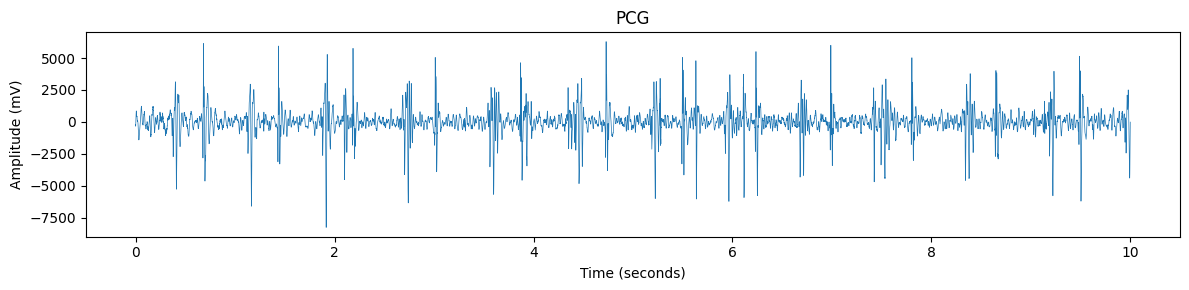

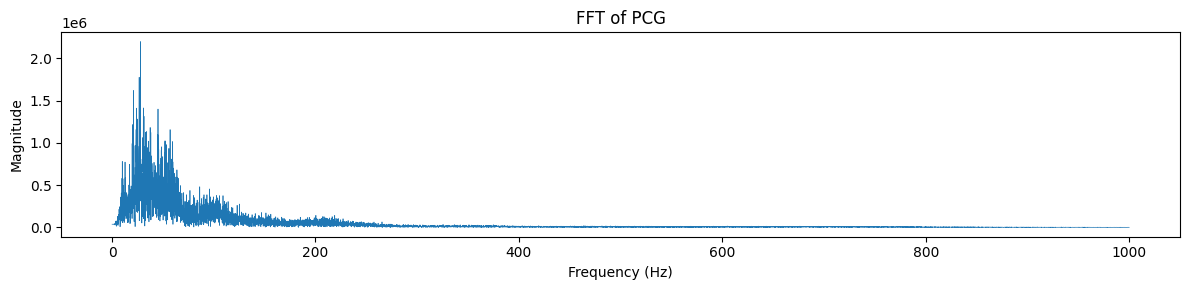

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

def parse_info(file_path):
    """
    Parameters:
    - file_path: str, path to the .info file. (DO NOT INCLUDE THE ".info" EXTENSION IN THE file_path!)
    Returns:
    - info: dict, containing parsed metadata.
    """
    info = {}
    # Read the file
    with open(file_path + ".info", 'r') as file:
        file = file.readlines()
        signals = []
        # Read the fixed information at the beginning
        info['Source'] = file[0].split(':', 1)[1]
        info['Rows'] = int(file[1].split(' ')[2])
        info['Columns'] = int(file[1].split(' ')[6])
        info['Duration'] = file[2].split(':', 1)[1]
        info['Sampling frequency'] = file[3].split('  ')[0].split(':')[1].strip()
        info['Sampling interval'] = file[3].split('  ')[1].split(':')[1].strip()
        # Read the info for each signal
        for line in file[5:-4]:
            signal = {}
            signal['Signal'] = line.split('\t')[1].strip()
            signal['Gain']   = float(line.split('\t')[2].strip())
            signal['Base']   = float(line.split('\t')[3].strip())
            signal['Units']  = line.split('\t')[4].strip()
            signals.append(signal)
        info['Signals'] = signals
    return info

def calibrate_signal(signal, base, gain):
    """
    Parameters:
    - signal: numpy array, the raw signal data.
    - base: float, the baseline offset to subtract.
    - gain: float, the gain factor to apply.
    Returns:
    - calibrated_signal: numpy array, the base and gain corrected signal.
    """
    return (signal - base) / gain

def plot_fft(signal, sampling_frequency, title='FFT of Signal'):
    """
    Parameters:
    - signal: numpy array, the time-domain signal.
    - sampling_frequency: float, the sampling frequency of the signal.
    - title: str, the title of the FFT plot.
    """
    n = len(signal)
    fft_values = np.fft.fft(signal)
    # Calculate frequencies based on sampling frequency
    fft_frequencies = np.fft.fftfreq(n, d=1/sampling_frequency)
    # Filter the frequencies to get only positives
    fft_values = np.abs(fft_values[fft_frequencies > 0])
    fft_frequencies = fft_frequencies[fft_frequencies > 0]
    plt.figure(figsize=(12, 3))
    plt.plot(fft_frequencies, fft_values, linewidth=0.5)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()

def plot_signals(file_path, idx=-1):
    """
    Parameters:
    - file_path: str, path to the .mat file. (DO NOT INCLUDE THE ".mat" EXTENSION IN THE file_path!)
    - idx: int, the index of the signal to be shown. -1 for all signals. Default is -1
    """
    mat_data = scipy.io.loadmat(file_path + ".mat")
    info = parse_info(file_path)
    sampling_frequency = int(info['Sampling frequency'][:-3])  # Remove ' Hz' suffix and convert to int
    if idx == -1:
        for idx, signal in enumerate(info["Signals"]):
            raw_signal = mat_data["val"][idx]
            unit = signal["Units"]
            calibrated_signal = calibrate_signal(raw_signal, signal["Base"], signal["Gain"])
            time_axis = np.arange(len(calibrated_signal)) / sampling_frequency  # Create time axis in seconds
            data = pd.DataFrame({
                'Time': time_axis,
                'Signal': calibrated_signal
            })
            #data = data[(data["Time"] <= 1.5) & (data["Time"] >= 1)]
            #data.to_csv(f'{file_path}_{signal["Signal"]}.csv', index=False)
            plt.figure(figsize=(12, 3))
            plt.plot(data["Time"], data["Signal"], linewidth=0.5)  # Plot against time
            plt.title(signal["Signal"])
            plt.xlabel("Time (seconds)")
            plt.ylabel(f"Amplitude ({unit})")
            plt.tight_layout()
            plt.show()
            plot_fft(calibrated_signal, float(info['Sampling frequency'][:-3]) , title=f"FFT of {signal['Signal']}")
    else:
        raw_signal = mat_data["val"][idx]
        signal = info["Signals"][idx]
        unit = signal["Units"]
        calibrated_signal = calibrate_signal(raw_signal, signal["Base"], signal["Gain"])
        time_axis = np.arange(len(calibrated_signal)) / sampling_frequency  # Create time axis in seconds
        data = pd.DataFrame({
            'Time': time_axis,
            'Signal': calibrated_signal
        })
        #data = data[(data["Time"] <= 12) & (data["Time"] >= 8)]
        #data.to_csv(f'{file_path}_{signal["Signal"]}.csv', index=False)
        plt.figure(figsize=(12, 3))
        plt.plot(data["Time"], data["Signal"], linewidth=0.5)  # Plot against time
        plt.title(signal["Signal"])
        plt.xlabel("Time (seconds)")
        plt.ylabel(f"Amplitude ({unit})")
        plt.tight_layout()
        plt.show()
        plot_fft(calibrated_signal, float(info['Sampling frequency'][:-3]) , title=f"FFT of {signal['Signal']}")


plot_signals("a0191m", 0)


## Task 2 - The abnormality (1 point)
*“The sound S2 is caused by the closure of the aortic and pulmonary valves. In some cases, both physiological and pathological, a split S2 is heard. With the split S2, the closure of the two valves does not occur together. Physiological S2 splitting in which the closing of the aortic valve precedes the closing of the pulmonic is normal. … Exaggerated splitting of the sound S2 may occur in right ventricular outflow tract obstruction (for example: pulmonary stenosis) and right bundle branch block (RBBB). … The wide split has a duration of about 50 ms compared to the normal split with the value .The measurement of the split S2, lower or higher than 30 ms, will easily make it possible to make a discrimination between the normal or pathological type."* [source](https://www.sciencedirect.com/science/article/pii/S0010482506000199)

Show splitting events on the plotted PCG signal. Are they physiological or pathological? (Use the ECG signal if you are unsure about the distinction of S1 and S2.)

In [2]:
mat_data = scipy.io.loadmat("a0191m.mat")
info = parse_info("a0191m")
sampling_frequency = int(info['Sampling frequency'][:-3])

raw_signal = mat_data["val"][0]
signal = info["Signals"][0]
unit = signal["Units"]
calibrated_signal = calibrate_signal(raw_signal, signal["Base"], signal["Gain"])
time_axis = np.arange(len(calibrated_signal)) / sampling_frequency  # Create time axis in seconds

pcg = pd.DataFrame({
    'Time': time_axis,
    'Signal': calibrated_signal
})

raw_signal = mat_data["val"][1]
signal = info["Signals"][1]
calibrated_signal = calibrate_signal(raw_signal, signal["Base"], signal["Gain"])

ecg = pd.DataFrame({
    'Time': time_axis,
    'Signal': calibrated_signal
})

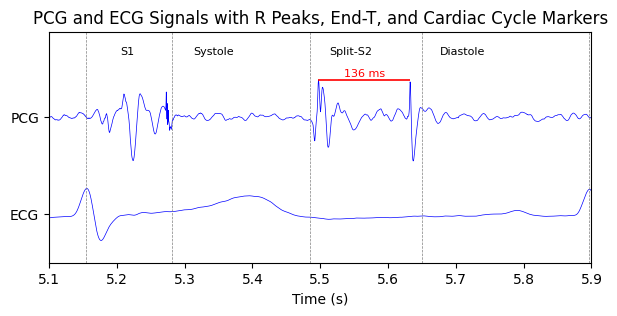

In [3]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(pcg["Time"], pcg["Signal"] * 0.0003, color="blue", linewidth=0.5, label="PCG")
ax.plot(ecg["Time"], ecg["Signal"] - 4, color="blue", linewidth=0.5, label="ECG")

vertical_line_indices = [5.155, 5.282, 5.485, 5.65, 5.897]
labels = ["S1", "Systole", "Split-S2", "Diastole", ""]

for x, label in zip(vertical_line_indices, labels):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
    if label:
        ax.text(x+0.06, 2.5, label, rotation=0, ha="center", va="bottom", fontsize=8, color="black")

split_start = 5.497
split_end = 5.6327
split_duration = split_end - split_start
split_duration *= 1000

# Draw the horizontal line between split_start and split_end at a fixed y-coordinate
ax.hlines(y=1.5, xmin=split_start, xmax=split_end, color="red", linewidth=1.2)
ax.text((split_start + split_end) / 2, 1.6, f"{split_duration:.0f} ms", ha="center", va="bottom", fontsize=8, color="red")

ax.set_yticks([0, -4])
ax.set_yticklabels(["PCG", "ECG"])

ax.set_ylim(-6, 3.5)
ax.set_xlim(5.1, 5.9)
ax.set_xlabel("Time (s)")
ax.set_title("PCG and ECG Signals with R Peaks, End-T, and Cardiac Cycle Markers")

plt.show()


Since the split is 136 ms and longer than 30 ms, we can say that it is a pathological split [source](https://www.sciencedirect.com/science/article/pii/S0010482506000199)

## Task 3 - STFT (3 point)
Implement your version of the STFT function. It should have the following format:
function ***my_stft(signal,fs,windowtype,windowlength)***

short time fourier transform   
**inputs**:
- *signal*:     the ignal to take the transform of, 1D array
- *fs*:         the sampling frequency of the signal
- *windowtype*: 0 for rectangular, 1 for hann window
- *widowsize*:  length of window in samples

**output**:
- subplots of the signal and a 'one-sided' STFT spectrogram, with proper time and frequency axes


Example run with ***my_stft(PCG,fs,0,100)***

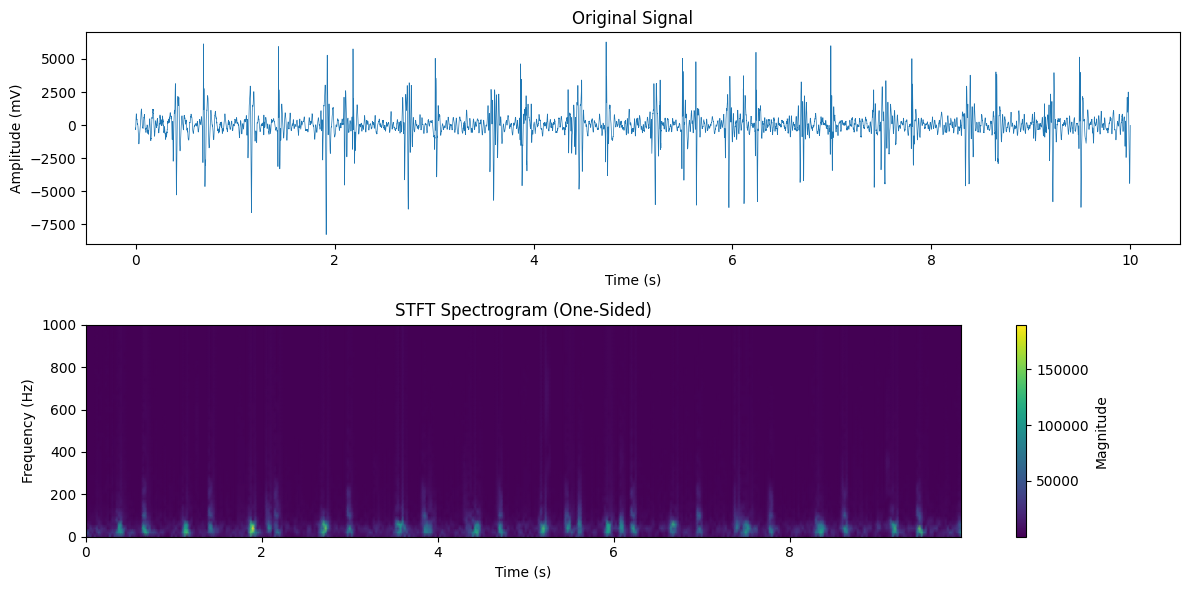

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def my_stft(signal, fs, windowtype, windowsize):
    if windowtype == 0:
        window = np.ones(windowsize)  # Rectangular window
    elif windowtype == 1:
        window = np.hanning(windowsize)  # Hann window
    else:
        raise ValueError("Invalid window type. Use 0 for rectangular or 1 for Hann window.")

    hop_size = windowsize // 2
    num_segments = int(np.ceil((len(signal) - windowsize) / hop_size)) + 1

    freqs = np.fft.rfftfreq(windowsize, d=1/fs)  # One-sided frequency axis
    times = np.arange(num_segments) * hop_size / fs  # Time axis for each segment

    stft_matrix = np.zeros((len(freqs), num_segments), dtype=np.complex64)

    for i in range(num_segments):
        start = i * hop_size
        end = start + windowsize
        if end > len(signal):
            segment = np.zeros(windowsize)  # Zero padding for the last segment
            segment[:len(signal) - start] = signal[start:]
        else:
            segment = signal[start:end]

        windowed_segment = segment * window
        segment_fft = np.fft.rfft(windowed_segment)
        stft_matrix[:, i] = segment_fft

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    time_axis = np.arange(len(signal)) / fs
    plt.plot(time_axis, signal, linewidth=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel(f"Amplitude ({unit})")
    plt.title("Original Signal")

    plt.subplot(2, 1, 2)
    plt.pcolormesh(times, freqs, np.abs(stft_matrix), shading='gouraud')
    plt.colorbar(label="Magnitude")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("STFT Spectrogram (One-Sided)")

    plt.tight_layout()
    plt.show()

# Example usage:
my_stft(pcg["Signal"], sampling_frequency, 0, 100)


## Task 4 - TF-uncertainty (2 point)
Explain and illustrate the time-frequency uncertainty with the help of your code and signal. When are the splits visible/localizable? How does the window-type influence this difference?

Time-frequency (TF) uncertainty, or the uncertainty principle in signal processing, states that there's a trade-off between time resolution and frequency resolution. When we analyze a signal with a Short-Time Fourier Transform (STFT), our ability to precisely identify both time and frequency information is limited by the window size. Smaller windows provide better time resolution but poorer frequency resolution, while larger windows provide better frequency resolution but poorer time resolution.

Rectangular Window: Provides sharp transitions but can introduce spectral leakage, making it harder to localize frequencies cleanly.

Hann Window: Smooths the edges of the window, reducing spectral leakage and providing cleaner frequency information. However, it slightly increases the blur around events in time.

Small Window Size (50 samples) - Better Time Resolution


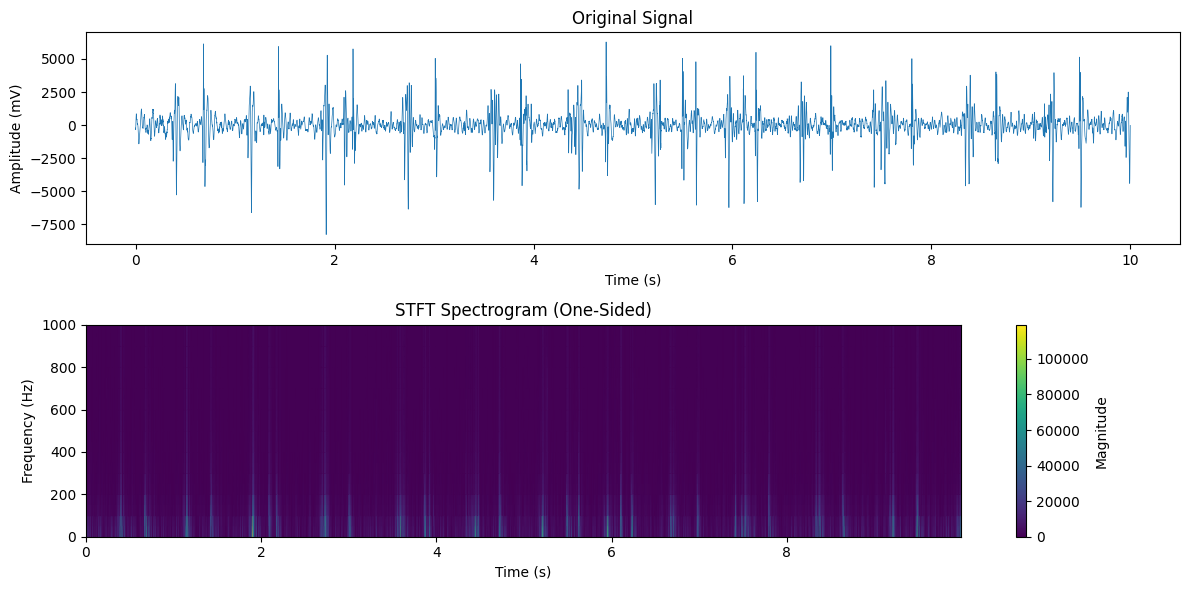

Large Window Size (200 samples) - Better Frequency Resolution


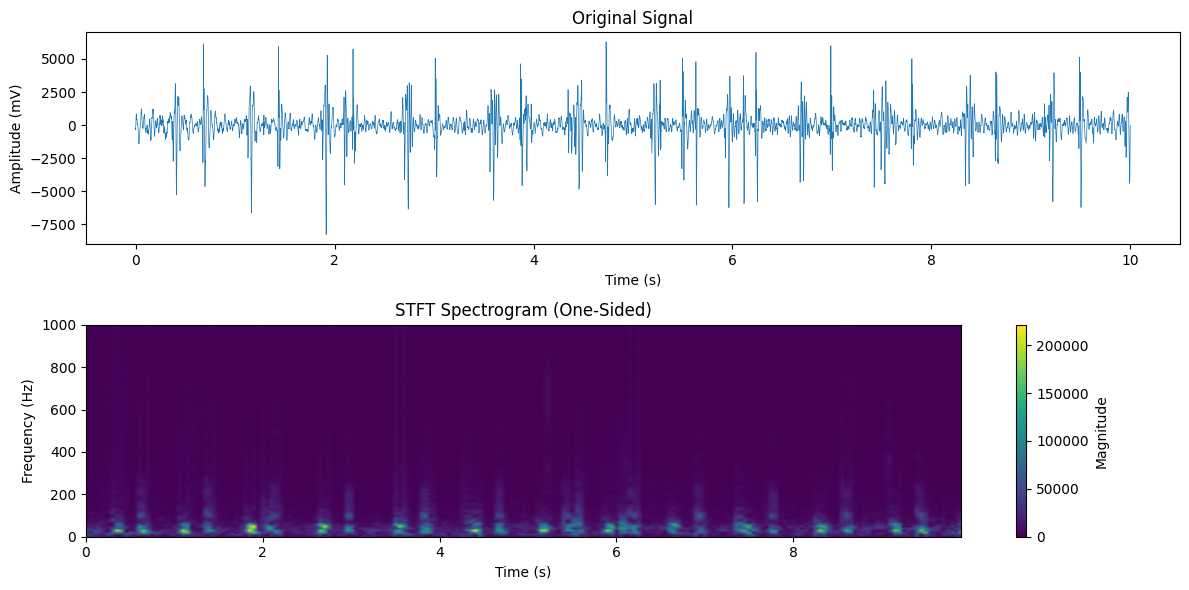

Small Window Size (50 samples) - Better Time Resolution


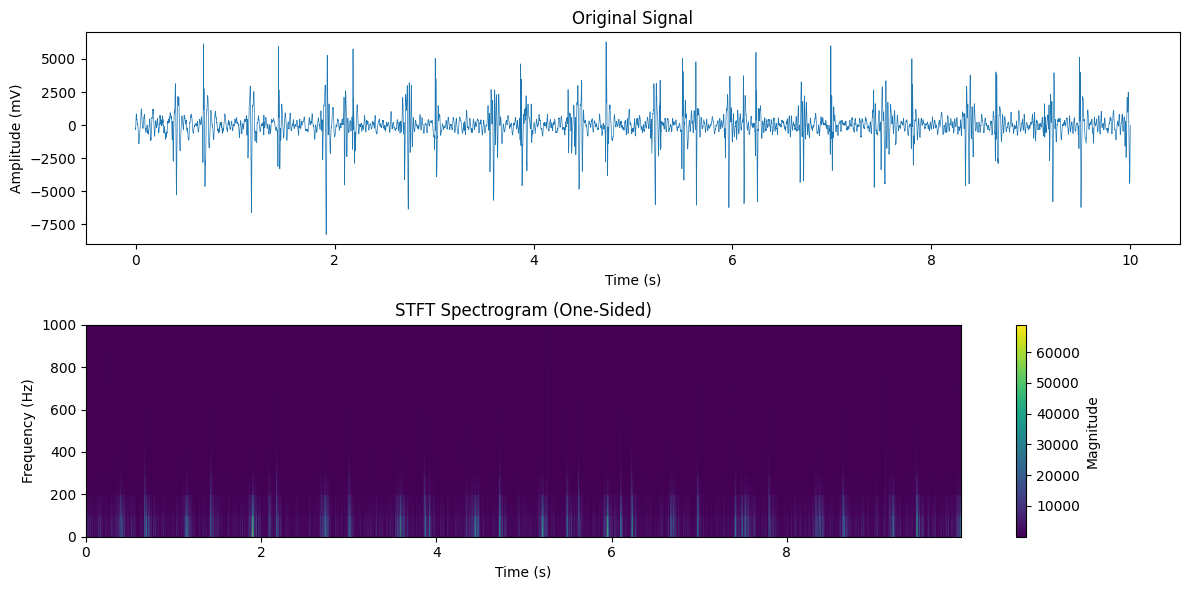

Large Window Size (200 samples) - Better Frequency Resolution


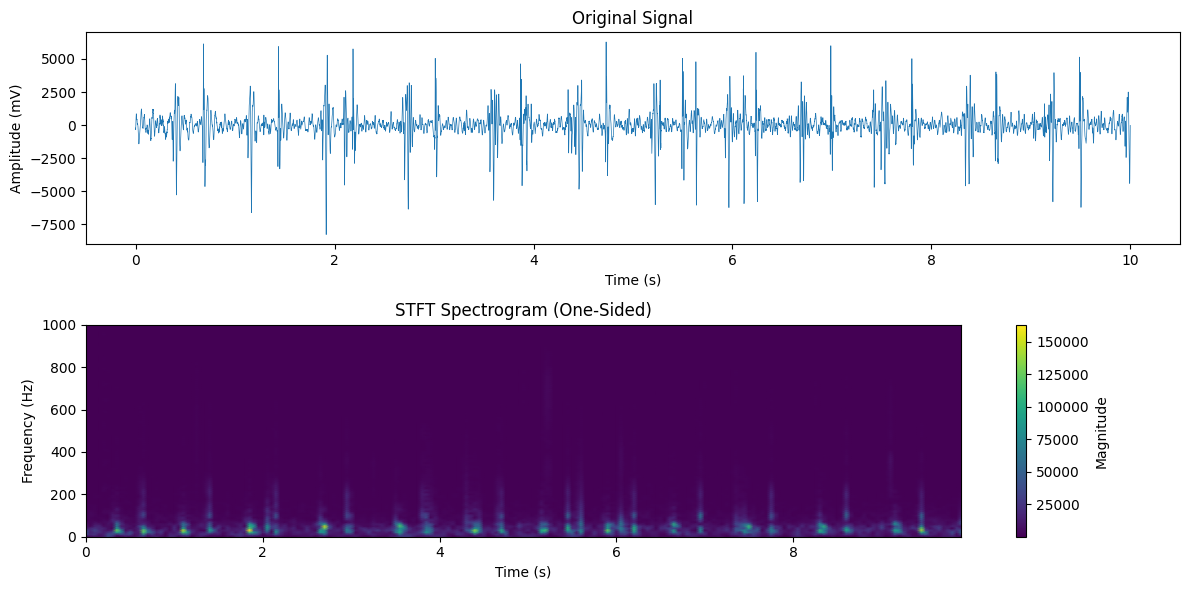

In [5]:
# Small window size - Rectangular window
print("Small Window Size (50 samples) - Better Time Resolution")
my_stft(pcg["Signal"], sampling_frequency, windowtype=0, windowsize=20)  # Rectangular window, small window size

# Large window size - Rectangular window
print("Large Window Size (200 samples) - Better Frequency Resolution")
my_stft(pcg["Signal"], sampling_frequency, windowtype=0, windowsize=200)  # Rectangular window, large window size

# Small window size - Hann window
print("Small Window Size (50 samples) - Better Time Resolution")
my_stft(pcg["Signal"], sampling_frequency, windowtype=1, windowsize=20)  # Hann window, small window size

# Large window size - Hann window
print("Large Window Size (200 samples) - Better Frequency Resolution")
my_stft(pcg["Signal"], sampling_frequency, windowtype=1, windowsize=200)  # Hann window, large window size

## Task 5 - CWT vs STFT in theory (1 point)
Explain in your own words, how is the STFT different from the CWT.


#### Resolution
- **STFT**: The STFT divides the signal into fixed-size time windows, and each window is analyzed with a Fourier transform to obtain frequency information. This fixed window size means the STFT has **constant resolution** in both time and frequency across the entire signal.
    - A **smaller window** gives better time resolution but poorer frequency resolution.
    - A **larger window** gives better frequency resolution but poorer time resolution.
    - This results in a trade-off: once a window size is chosen, the resolution cannot adapt to different frequencies in the signal.

- **CWT**: The CWT, in contrast, uses **scalable wavelets** that adjust in width, providing variable resolution across the signal. For high frequencies, the CWT uses narrower wavelets to give good time resolution, while for low frequencies, it uses wider wavelets for better frequency resolution. This means the CWT has **adaptive resolution**:
    - **High frequencies** are captured with better time resolution and lower frequency resolution.
    - **Low frequencies** are captured with better frequency resolution and lower time resolution.
    - This adaptability allows the CWT to capture both sharp, short-duration events (like spikes) and smooth, long-duration events (like low-frequency oscillations) within the same transform.

#### Basis Functions
- **STFT**: Uses **sine and cosine waves** as basis functions. This is ideal for analyzing periodic or quasi-periodic components, as these basis functions are well-suited for stationary signals.
- **CWT**: Uses **wavelets** (localized wave packets that are stretched and compressed versions of a chosen wavelet function) as basis functions. Wavelets are localized in both time and frequency, making them ideal for analyzing signals with transients, sharp changes, or non-stationary behavior.

## Task 6 - CWT in practice (1 point)
Use the cwt() function of PyWavelets to obtain the continuous wavelet transform of the PCG signal, and plot it. How is CWT discretized in Python? Which method would you recommend for detecting the split?

In [6]:
!pip install PyWavelets

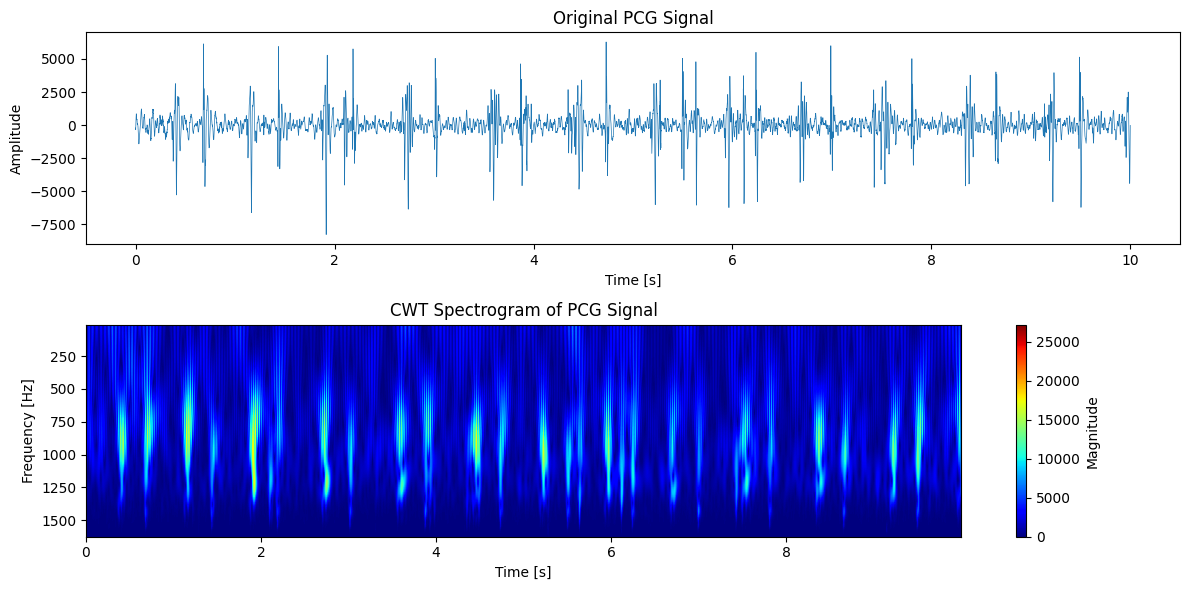

In [7]:
import pywt

pcg_signal = pcg['Signal'].values
fs = sampling_frequency

scales = np.arange(1, 128)

coefficients, frequencies = pywt.cwt(pcg_signal, scales, 'morl', sampling_period=1/fs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(pcg['Time'], pcg_signal, linewidth=0.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original PCG Signal")

plt.subplot(2, 1, 2)
plt.imshow(np.abs(coefficients), extent=[pcg['Time'].min(), pcg['Time'].max(), frequencies.min(), frequencies.max()],
           cmap='jet', aspect='auto', vmax=np.abs(coefficients).max(), vmin=0)
plt.colorbar(label="Magnitude")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("CWT Spectrogram of PCG Signal")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In Python’s **PyWavelets** library, the `cwt()` function discretizes the CWT in two main ways:
1. **Scales**: The `scales` parameter defines discrete scales to apply the wavelet transform. Each scale corresponds to a specific frequency range in the signal, where higher scales capture lower frequencies and vice versa.
2. **Discrete Time Steps**: Since the input signal is sampled, the CWT produces discrete values in both time and scale, yielding a time-frequency representation that is not fully continuous but rather an approximation with chosen time and scale steps.

The output `coefficients` matrix is an array of wavelet coefficients for each time-scale combination, representing the signal’s energy at specific frequencies over time.

When detecting a **split** (e.g., the S2 split) in a signal like PCG, the **CWT** can be particularly effective because the CWT offers better time localization at higher frequencies (smaller scales), making it easier to detect rapid, short-duration events such as the splitting of heart sounds. On the other hand, since the CWT uses wavelets, it tends to localize energy around transient features like splits more effectively than the STFT, which uses fixed-size windows.

While **STFT** works well for stationary or slowly varying signals, the **CWT** is typically better for split detection in heart sounds because heart sound splits are short-duration events that benefit from the CWT’s better time resolution at high frequencies. Also, the CWT’s adaptability to different scales allows it to highlight the high-frequency components associated with the split, which may be blurred by the fixed-window STFT.

## Task 7 - pyPCG (5 point)

- Install pyPCG, read in the data and visualize it. Why is the sample rate so low?
- Show the spectrogram of a heart cycle from each example file. How does this relate to S1 split?
- Improve the example code with preprocessing or other methods. Give a reason for their inclusion.
- Calculate new features not shown in the example.
- Run your methods on the "non-example" files. Try to classify them.
- (Do not use the heart sound label file. Try to implement a peak detection method - extra point)

In [8]:
!pip install git+https://github.com/jvkersch/hsmmlearn@master
!pip install pyPCG_toolbox
!pip install ipympl

  Cloning https://github.com/jvkersch/hsmmlearn (to revision master) to /tmp/pip-req-build-l2m5pgxc
  Running command git clone --filter=blob:none --quiet https://github.com/jvkersch/hsmmlearn /tmp/pip-req-build-l2m5pgxc
  Resolved https://github.com/jvkersch/hsmmlearn to commit 69bc8aafb53033596e6a314d314547c6f2d197f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Sampling Rate of Example 1: 333
Sampling Rate of Example 2: 333


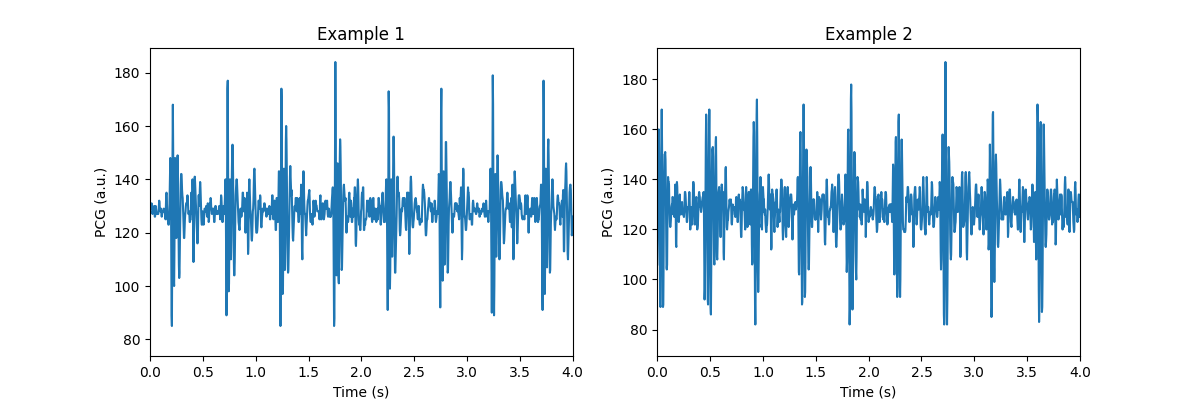

In [9]:
import pyPCG, pyPCG.io, pyPCG.segment, pyPCG.preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

signal1, fs1 = pyPCG.io.read_signal_file(f"example_1.wav","wav")
signal1 = pyPCG.pcg_signal(signal1, fs1, [f"Example 1"])

signal2, fs2 = pyPCG.io.read_signal_file(f"example_2.wav","wav")
signal2 = pyPCG.pcg_signal(signal2, fs2, [f"Example 2"])


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
pyPCG.plot(signal1,xlim=(0,4))
plt.subplot(1,2,2)
pyPCG.plot(signal2,xlim=(0,4))

print("Sampling Rate of Example 1:", fs1)
print("Sampling Rate of Example 2:", fs2)

Heart sounds, such as S1 and S2, typically lie within a frequency range of 20–150 Hz. A sampling rate of 333 Hz is above the Nyquist rate for these frequencies, meaning it can accurately capture the key components of the heart sounds. By using lower sampling rates, we can reduce data size and processing requirements, making analysis more efficient without sacrificing the essential details of the PCG signal. Also by using a lower sampling rate, we avoid capturing unnecessary high-frequency noise, which is outside the frequency range of interest for heart sound analysis.

### Show the spectrogram of a heart cycle from each example file. How does this relate to S1 split?

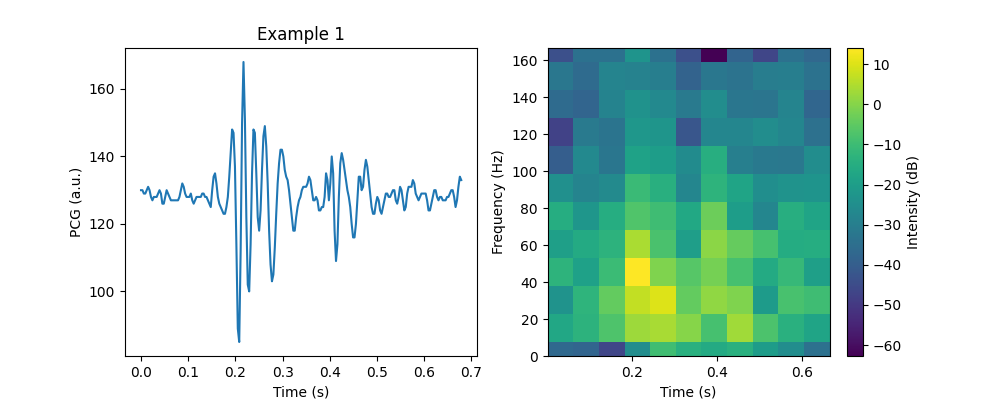

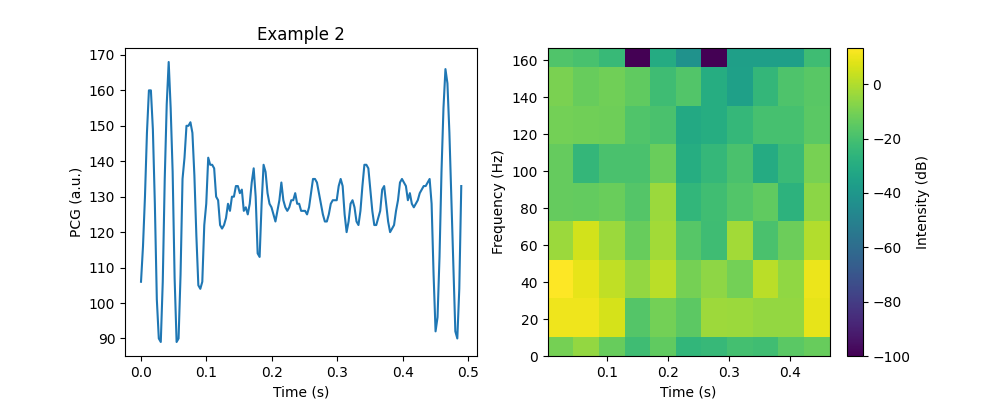

In [10]:
from scipy.signal import spectrogram
def plot_heart_cycle_spectrogram(signal, fs, start_time, end_time, title="Heart Cycle Spectrogram"):
    plt.figure(figsize=(10,4))
    signal = signal[0:int(end_time*fs)]
    signal_pcg = pyPCG.pcg_signal(signal,fs, title)
    plt.subplot(1,2,1)
    pyPCG.plot(signal_pcg)
    #plt.xlim(start_time, end_time)
    plt.title(title)
    #plt.axvline(vlines[i], color='r')

    freq, time, spec = spectrogram(signal, fs=fs, nperseg=len(signal)//10)
    spec = 10 * np.log10(spec + 1e-10)  # Convert to dB

    plt.subplot(1,2,2)
    plt.pcolormesh(time, freq, spec, shading='auto')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.ylim([0, fs / 2])
    plt.colorbar(label="Intensity (dB)")
    plt.show()

# Example times for heart cycles (update with actual heart cycle times if available)
# Plot spectrograms for each example
signal1, fs1 = pyPCG.io.read_signal_file(f"example_1.wav","wav")
signal2, fs2 = pyPCG.io.read_signal_file(f"example_2.wav","wav")
plot_heart_cycle_spectrogram(signal1, fs1, start_time=0, end_time=0.68, title="Example 1")
plot_heart_cycle_spectrogram(signal2, fs2, start_time=0, end_time=0.49, title="Example 2")

### Improve the example code with preprocessing or other methods. Give a reason for their inclusion.

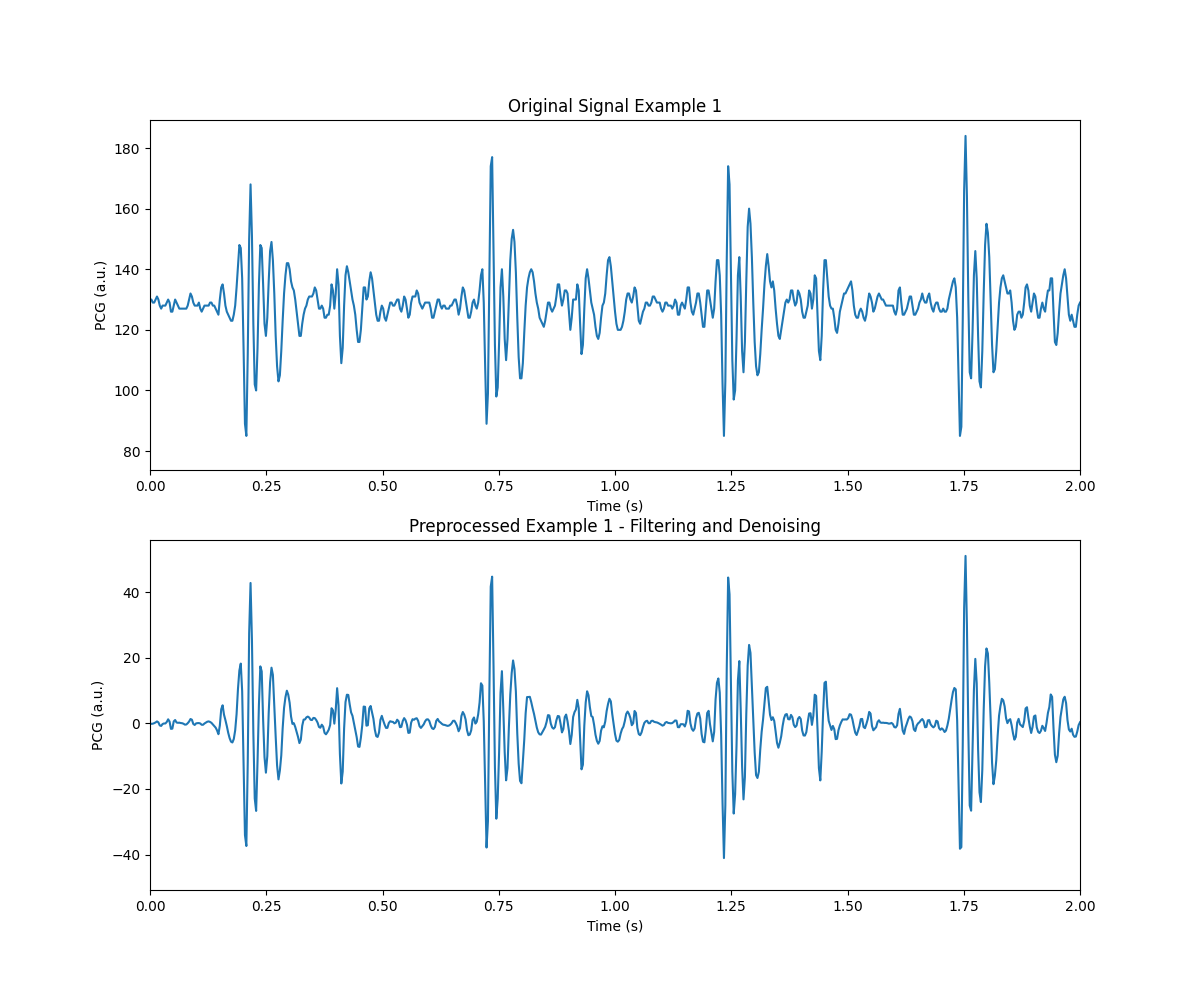

In [11]:
from scipy.signal import butter, filtfilt

# Load the PCG signal and annotation labels
signal_, fs = pyPCG.io.read_signal_file("example_1.wav", "wav")
labels = pyPCG.io.read_hsannot_file("example_1.csv")
s1_label = np.array(labels[0])
s2_label = np.array(labels[1])


# Bandpass filter to remove noise outside heart sound frequency range (20–150 Hz)
def bandpass_filter(signal, fs, lowcut=20, highcut=150):
    nyquist = fs/2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(3, [low, high], btype="band")
    return filtfilt(b, a, signal)

filtered_signal = bandpass_filter(signal_, fs)

# Wavelet denoising to enhance signal quality
def wavelet_denoise(signal):
    coeffs = pywt.wavedec(signal, "db4", level=5)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    denoised_coeffs = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    return pywt.waverec(denoised_coeffs, "db4")

denoised_signal = wavelet_denoise(filtered_signal)

# Plot the original, filtered, and denoised signals
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
pyPCG.plot(pyPCG.pcg_signal(signal_, fs), xlim=(0,2))
plt.title("Original Signal Example 1")
plt.subplot(2,1,2)
pyPCG.plot(pyPCG.pcg_signal(denoised_signal, fs, ["Example 1"]), xlim=(0,2))
plt.title("Preprocessed Example 1 - Filtering and Denoising")
plt.show()


### Calculate new features not shown in the example

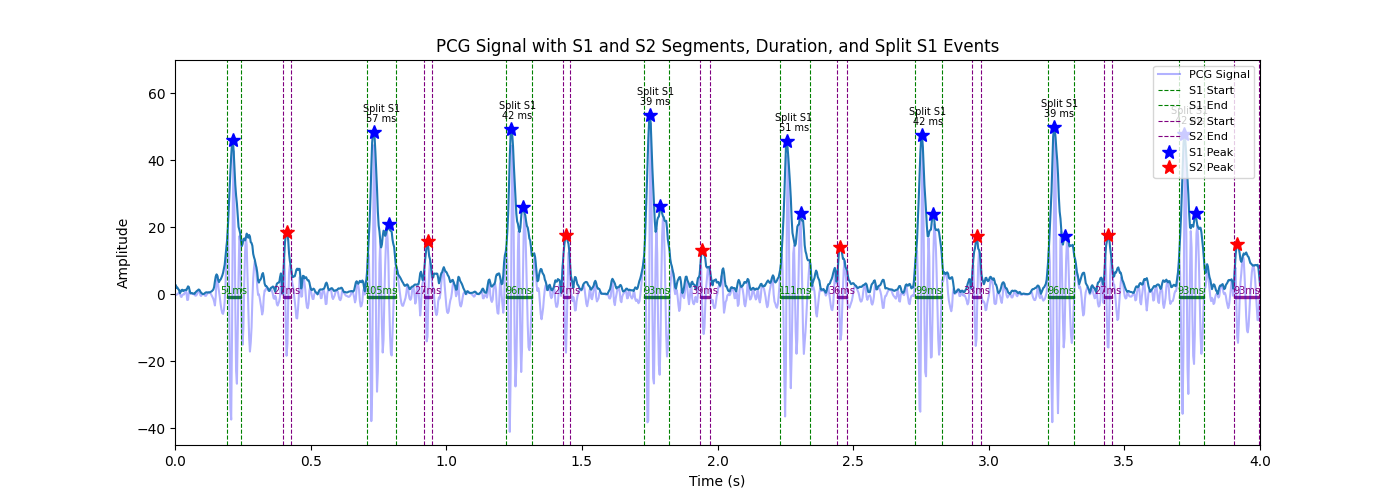

In [20]:
def newFeatures(filename, x_start_limit, x_end_limit):
  signal_, fs = pyPCG.io.read_signal_file(f"{filename}.wav", "wav")
  labels = pyPCG.io.read_hsannot_file(f"{filename}.csv")
  s1_label = np.array(labels[0])
  s2_label = np.array(labels[1])

  denoised_signal = wavelet_denoise(filtered_signal)

  from scipy.signal import find_peaks

  envelope = pyPCG.preprocessing.envelope(pyPCG.pcg_signal(denoised_signal, fs, ["Example 1"]))

  s1_indices = np.round(s1_label* fs).astype(int)
  s2_indices = np.round(s2_label* fs).astype(int)

  s1_starts, s1_ends = pyPCG.segment.segment_peaks(s1_indices, envelope)
  s2_starts, s2_ends = pyPCG.segment.segment_peaks(s2_indices, envelope)

  def calculate_duration(starts, ends, fs):
      return (ends - starts) / fs  # Duration in seconds

  s1_durations = calculate_duration(s1_starts, s1_ends, fs)
  s2_durations = calculate_duration(s2_starts, s2_ends, fs)

  def detect_peaks_within_segment(signal, start_idx, end_idx, distance, threshold):
      segment_peaks, _ = find_peaks(signal[start_idx:end_idx], distance=distance, height=threshold)
      return segment_peaks + start_idx

  # Define parameters for peak detection
  peak_distance = int(0.04 * fs)  # Minimum distance between peaks in samples
  peak_threshold = 0.2 * np.max(envelope.data)  # Threshold for envelope peaks

  # Lists to hold detected S1 and S2 peaks, and split S1 events
  s1_peaks = []
  s2_peaks = []
  split_s1_events = []

  # Detect S1 peaks within each S1 start-end segment and check for splits
  for start, end in zip(s1_starts, s1_ends):
      peaks_in_segment = detect_peaks_within_segment(envelope.data, start, end, peak_distance, peak_threshold)
      s1_peaks.extend(peaks_in_segment)

      # If there are two or more peaks within this S1 segment, mark it as a split
      if len(peaks_in_segment) > 1:
          split_s1_events.append((peaks_in_segment[0], peaks_in_segment[-1]))

  # Detect S2 peaks within each S2 start-end segment
  for start, end in zip(s2_starts, s2_ends):
      peaks_in_segment = detect_peaks_within_segment(envelope.data, start, end, peak_distance, peak_threshold)
      s2_peaks.extend(peaks_in_segment)

  plt.figure(figsize=(14, 5))

  # Plot the PCG signal and its envelope with S1, S2 peaks, and split S1 markers
  plt.plot(np.arange(len(denoised_signal)) / fs, denoised_signal, label="PCG Signal", color="blue", alpha=0.3)
  pyPCG.plot(envelope, xlim=(x_start_limit, x_end_limit))

  # Plot S1 and S2 start/end markers with rectangles showing duration and stars on peaks
  for start, end in zip(s1_starts, s1_ends):
      start_time, end_time = start / fs, end / fs
      duration = end_time - start_time

      # Plot vertical lines for S1 start and end within the x-axis limit
      if x_start_limit <= start_time <= x_end_limit:
          plt.axvline(start_time, color="green", linestyle="--", linewidth=0.8, label="S1 Start" if start == s1_starts[0] else "")
      if x_start_limit <= end_time <= x_end_limit:
          plt.axvline(end_time, color="green", linestyle="--", linewidth=0.8, label="S1 End" if start == s1_starts[0] else "")

      # Plot S1 duration rectangles within x-axis limits
      if start_time < x_end_limit and end_time > x_start_limit:
          plt.gca().add_patch(plt.Rectangle((start_time, -1), duration, 0.5, color="green", alpha=0.8))
          plt.text(start_time + duration / 2, 0, f"{duration*1000:.0f}ms", ha="center", color="green", fontsize=7)

  # Plot S2 start/end markers similarly
  for start, end in zip(s2_starts, s2_ends):
      start_time, end_time = start / fs, end / fs
      duration = end_time - start_time

      # Plot vertical lines for S2 start and end within the x-axis limit
      if x_start_limit <= start_time <= x_end_limit:
          plt.axvline(start_time, color="purple", linestyle="--", linewidth=0.8, label="S2 Start" if start == s2_starts[0] else "")
      if x_start_limit <= end_time <= x_end_limit:
          plt.axvline(end_time, color="purple", linestyle="--", linewidth=0.8, label="S2 End" if start == s2_starts[0] else "")

      # Plot S2 duration rectangles within x-axis limits
      if start_time < x_end_limit and end_time > x_start_limit:
          plt.gca().add_patch(plt.Rectangle((start_time, -1), duration, 0.5, color="purple", alpha=0.8))
          plt.text(start_time + duration / 2, 0, f"{duration*1000:.0f}ms", ha="center", color="purple", fontsize=7)

  # Plot S1 and S2 peaks as stars
  s1_peaks_in_range = [peak for peak in s1_peaks if x_start_limit <= peak / fs <= x_end_limit]
  s2_peaks_in_range = [peak for peak in s2_peaks if x_start_limit <= peak / fs <= x_end_limit]
  plt.plot(np.array(s1_peaks_in_range) / fs, envelope.data[s1_peaks_in_range], 'b*', markersize=10, label="S1 Peak")
  plt.plot(np.array(s2_peaks_in_range) / fs, envelope.data[s2_peaks_in_range], 'r*', markersize=10, label="S2 Peak")

  # Indicate split S1 events only within the x-axis limit
  for split_start, split_end in split_s1_events:
      split_start_time = split_start / fs
      split_end_time = split_end / fs
      split_duration = (split_end_time - split_start_time) * 1000  # Convert to milliseconds

      # Only plot the split indicator if it's within x-axis limits
      if x_start_limit <= split_start_time <= x_end_limit and x_start_limit <= split_end_time <= x_end_limit:
          plt.text((split_start_time + split_end_time) / 2, envelope.data[split_start]+6, f"Split S1", ha="center", color="black", fontsize=7)
          plt.text((split_start_time + split_end_time) / 2, envelope.data[split_start]+3, f"{split_duration:.0f} ms", ha="center", color="black", fontsize=7)

  # Set x-axis limit
  plt.ylim(-45, 70)
  plt.xlim(x_start_limit, x_end_limit)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("PCG Signal with S1 and S2 Segments, Duration, and Split S1 Events")
  plt.legend(loc="upper right", fontsize=8)
  plt.show()


newFeatures("example_1", 0, 4)

### Run your methods on the "non-example" files. Try to classify them.

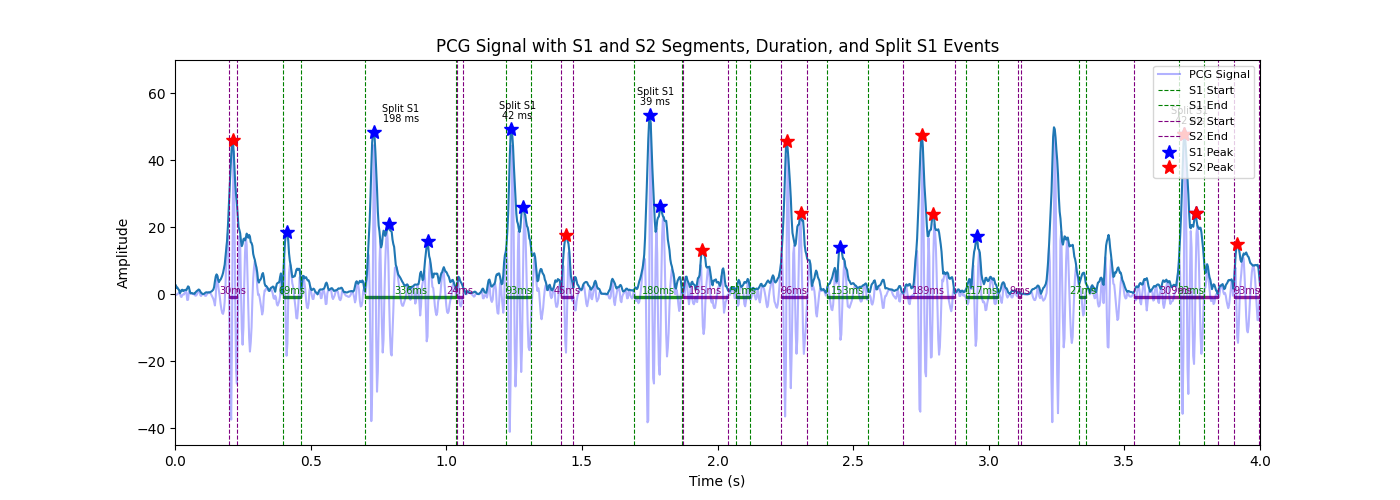

In [21]:
newFeatures("task_7.1", 0, 4)

# Lecture Notes

## Week 6 - Spectral Estimation

The Fourier transform is used for denoising, filtering, image restoration, and solving differential equations. The Fourier slice theorem is crucial for spectrum and Fourier analysis.

### What is a Spectrum?
*A spectrum* is the distribution of a signal’s power or intensity across different frequencies, often visualized in spectral density functions (Oppenheim et al., 1997).

### Fourier Transform
The Fourier transform decomposes a signal into its frequency components and is essential in applications like signal processing. Listening involves Fourier transform and spectrum analysis, as the ear distinguishes various voice frequencies. The eye has rods that send information to the brain, which also processes it in a similar frequency-based way.

In the past, analytical computers were used to calculate the Fourier transform. It’s also useful for light spectrum analysis to identify different molecules. 

### Non-Parametric Methods

#### Concept of Vector and Function Basis
A signal can be composed of sines and cosines. Two arrays or basis functions can form any possible vector, and each vector can be projected onto another using the dot product. Similarly, functions can be represented through a dot product with basis functions, producing a series of coordinates which make up the spectrum. This is periodic and orthogonal.

#### Fourier Series
The Fourier series represents periodic signals as sums of sinusoidal functions with different frequencies, amplitudes, and phases. 

#### Fourier Transform
The Fourier transform applies to any signal in the complex domain. Complex spirals represent the Euler function's sines and cosines, resulting in an amplitude spectrum and a phase spectrum (a shift of the sine function). The inverse of phase gives an outline of the image.

#### Fourier Series to Transform
The Fourier series generalizes to the Fourier transform for continuous, non-repeating signals. Both rely on orthogonal functions, enabling signal decomposition and analysis.

#### Phase Wrapping
Phase wrapping restricts the domain between -π and π, creating a “wrapped” effect that prevents abrupt shifts in the phase.

#### Problems with FFT

##### Nyquist Theorem
The Nyquist theorem requires that the sampling frequency be at least twice the highest frequency in the signal to avoid distortion. If the sampling rate is too low, aliasing can occur, distorting the frequency.

Newsreporters do not wear striped clothes since it is hard to differentiate in pattern in the image. The wheels on formula cars appear to be rotating backwards since the camera cannot track the wheels on video. The same phenomena can be observed on helicopter wings (Smith, 2002).

##### Spectral Leakage
Spectral leakage occurs when the spectrum “leaks” due to incomplete signal resolution. A square wave in the frequency domain, for example, translates into a sinc function in the time domain. Filtering and recording may introduce leakage, which affects clarity. 

##### Aliasing
The Fourier transform repeats from -∞ to +∞, and if the sampling frequency is too low, the frequency periods overlap, causing a "caving" effect. Higher notes may interfere with lower ones.

##### Anti-Aliasing
Applying a low-pass filter before recording reduces aliasing, though it may cause slight blurring.

*Main Lobe of a Signal:* Ultrasound has main lobes and side lobes. Main lobes that don’t overlap can distinguish frequencies, such as differentiating between 150 Hz and 140 Hz at fs = 1 kHz.

$$ w_{in} = \frac{f_s}{L} $$

#### Periodogram
The periodogram is the Fourier transform of a function's autocorrelation, and the squared Fourier transform gives the periodogram (Priestley, 1981).

#### Minimum Variance
Filter banks are used to separate signal components with minimal overlap, improving the spectral resolution by isolating frequency bands.

#### Multi-Taper Methods (Slepian, Sine, Welch's)
Multi-taper methods apply several windowing functions to obtain a more stable spectral estimate. This approach reduces leakage and is effective for signals with broad frequencies or low signal-to-noise ratios (Slepian, 1983).

### Parametric Spectrum Analysis
In parametric analysis, we model the signal spectrum based on certain assumptions, which helps with limited sample data.

#### AR Models
In an AR model, each sample in a signal is expressed as a linear combination of its previous samples, plus a noise term. This approach assumes that a signal can be accurately represented by a set of past values (Priestley, 1981).

##### AR Model Structure
The AR model of order *p* can be represented as:
$$
x[n] = \sum_{k=1}^{p} a_k x[n-k] + e[n]
$$
where:
- $ x[n] $ is the signal at time *n*,
- $ a_k $ are the AR model coefficients,
- $ e[n] $ is a white noise error term.

##### AR Model Transfer Function
The transfer function $ H(z) $ of the AR model is given by:
$$
H(z) = \frac{1}{1 - \sum_{k=1}^{p} a_k z^{-k}}
$$

This transfer function can be used to derive the power spectral density (PSD) of the signal.

##### Solving for $ a_k $: Autocorrelation Method
The autocorrelation method is commonly used to estimate the AR model coefficients $ a_k $. It relies on solving the Yule-Walker equations, which are derived from the autocorrelation function of the signal. The Yule-Walker equations for an AR model of order *p* can be written as:

$$
R \mathbf{a} = \mathbf{r}
$$

where:
- $ R $ is the $ p \times p $ autocorrelation matrix with elements $ R_{ij} = \text{E}[x[n-i] x[n-j]] $,
- $ \mathbf{a} $ is the vector of AR coefficients $ [a_1, a_2, \dots, a_p]^T $,
- $ \mathbf{r} $ is the vector of autocorrelations $ [r_1, r_2, \dots, r_p]^T $.

By solving these equations, we can obtain the coefficients $ a_k $ that minimize the prediction error, allowing the AR model to best represent the signal's structure based on its past values.

#### Maximum Entropy Method

This method maximizes the entropy of the signal under the constraints provided by the known autocorrelation values.

##### Entropy of a Signal

The maximum entropy principle suggests selecting the model that maximizes randomness (entropy), constrained by the observed data.

##### Maximum Entropy Spectral Estimation
The spectral estimate from the maximum entropy method is given by:
$$
P(f) = \frac{\sigma^2}{|1 - \sum_{k=1}^{p} a_k e^{-j 2 \pi f k}|^2}
$$
where:
- $ P(f) $ is the power spectral density,
- $ \sigma^2 $ is the variance of the white noise term $ e[n] $,
- $ a_k $ are the AR coefficients

Since the AR coefficients are estimated using the same process as in the AR model, maximum entropy provides a smooth and high-resolution spectral estimate, making it ideal for data with limited samples.

### Fourier Transform of a Discrete Signal

#### Comb Function
The comb function is a series of Dirac delta functions. Convolution with a sine function creates repeated peaks, forming a point process.

In imaging, Fourier transforms use 2D sines, and peaks occur at repeating distances, as seen in patterns like cardiac events in an ECG signal.

Cardiac events repeat. The comb function is convolved with the spectrum of a single ECG. 

### Point processes

There is cavitation in fluids which causes the pressure and boiling point to change. Gases are formed and explosions and bursts occur. In ultrasounds, fats and lipids are destroyed due to cavitation. Since tumours are resistant to drugs, cavitation is used to burst drugs into cells. 

For regular distances in the spectrum, we need events at regular intervals. When events are irregular, the spectrum spreads.

A Fourier transform in ultrasound is applied in three dimensions. The 3D volume is then flattened, and zooming into the Fourier transform reveals peaks. A second Fourier transform can indicate the length of the original signal by separating the dimensions.

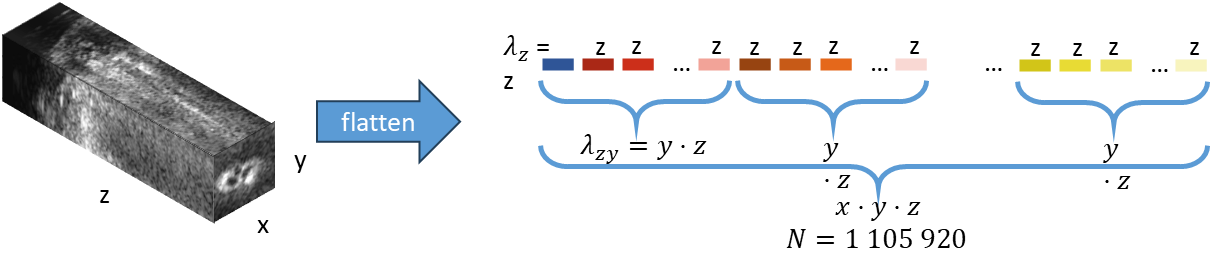


## Week 7 - Wavelets

### Spectrum of Non-Stationary Signals

In the case of windowed FFT, the spectrum windows can overlap. Spectrograms are commonly used to analyze bird songs and biomedical signals. There are shifts between windows, known as "spectral leakage." A shorter window provides better temporal resolution, but this causes frequency spreading (Oppenheim et al., 1997).

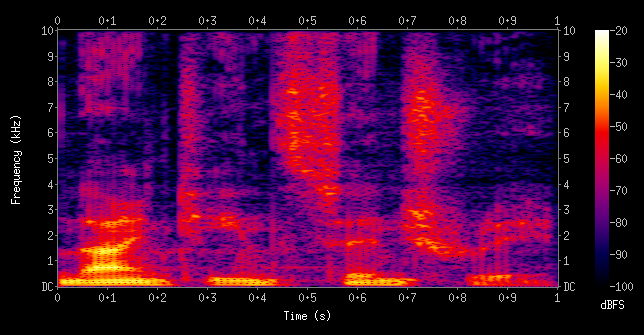

By <a href="//commons.wikimedia.org/w/index.php?title=User:Aquegg&amp;action=edit&amp;redlink=1" class="new" title="User:Aquegg (page does not exist)">Aquegg</a> - <span class="int-own-work" lang="en">Own work</span>, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=5544473">Link</a>

### Short-Time Fourier Transform

The Short-Time Fourier Transform (STFT) divides a signal into segments, typically using a window function, and computes the FFT for each segment. This allows for time-frequency analysis, making it useful for non-stationary signals  (Allen & Rabiner, 1977).

### Time-Frequency Uncertainty

The time-frequency uncertainty principle states that a signal cannot be simultaneously localized in both time and frequency. A shift in time corresponds to multiplication by an exponential function in the Fourier domain (Cohen, 1995).

#### Window Types

Various window functions (e.g., rectangular, Gaussian, Hamming) are used in the STFT to balance the trade-off between time and frequency resolution. The optimal window type depends on the signal's characteristics and the analysis requirements. For example, Gaussian windows minimize uncertainty, while rectangular windows provide sharp frequency components at the expense of time resolution.

### Rectangular Fourier Window

When using a rectangular window, its Fourier Transform is a sinc function, leading to spectral leakage. The width of the sinc function depends on the number of samples in the window. The relationship between time and frequency uncertainty is given by:

$$
\Delta t \cdot \Delta f \approx 0.603
$$

To reduce this uncertainty, alternative window types can be employed.

### Gaussian Window

For the Gaussian window, the time width $\Delta t$ and the frequency width $\Delta f$ are inversely related, and the product of their uncertainties is minimized:

$$
\Delta t \cdot \Delta f = \frac{2 \ln(2)}{\pi} \approx 0.4412
$$

In this case, the signal is multiplied by the window, and the Fourier transform is computed over different time shifts.

### Gabor Functions

A Gabor function is obtained by multiplying a complex sinusoid by a Gaussian window. The resulting signal is convolved with the Gabor window, enabling analysis of the frequency components with both time and frequency localization (Gabor, 1946).

We can observe the Doppler effect in ultrasounds. Generally, the sound source is moving; however, in ultrasound imaging, it is the blood that moves while the sound source remains stationary. This effect is especially visible when measuring the fetal heartbeat due to the heart's movement.

The number of oscillations in the Gabor window can be fixed, providing control over both time and frequency resolution.

#### Fixed Window and Fixed Cycles

When using fixed windows with a fixed number of cycles, the time and frequency resolution are predetermined (Cohen, 1995).

1. **Fixed Windows with Variable Cycles**: Maintains consistent time resolution while adjusting frequency resolution based on the cycle count.

2. **Fixed Cycles with Variable Windows**: Keeps frequency resolution steady, allowing time resolution to change with window size.

### Wavelets

Wavelets have zero integral and finite absolute values, making them well-suited for time-frequency analysis. (Daubechies, 1992)

#### Mother Wavelet

A **mother wavelet** is the prototype wavelet that can be scaled and shifted to form different daughter wavelets. It defines the fundamental shape of the wavelet used in the transform.

A **daughter wavelet** is a shifted and scaled version of the mother wavelet, used to analyze the signal at different scales and positions.

In Continuous Wavelet Transform (CWT), the signal is convolved with the mother wavelet, which provides time-frequency analysis with better localization compared to the Fourier transform.

#### Overcomplete Wavelet Transform

An overcomplete wavelet transform occurs when the wavelet transform is applied with redundant or overlapping scales and shifts, providing more detailed frequency information but at the cost of increased computational complexity.

## References

Oppenheim, A. V., & Schafer, R. W. (1997). Discrete-Time Signal Processing (2nd ed.). Prentice-Hall.

Cohen, L. (1995). Time-Frequency Analysis. Prentice-Hall.

Gabor, D. (1946). Theory of Communication. Journal of the Institution of Electrical Engineers.

Priestley, M. B. (1981). Spectral Analysis and Time Series. Academic Press.

Slepian, D. (1983). The Use of Discrete Sequences in Communications and Radar. IEEE Transactions on Information Theory.

Smith, S. W. (2002). The Scientist and Engineer's Guide to Digital Signal Processing. California Technical Publishing.

Allen, J. B., & Rabiner, L. R. (1977). A Unified Approach to Short-Time Fourier Analysis and Synthesis. Proceedings of the IEEE.

Daubechies, I. (1992). Ten Lectures on Wavelets. SIAM.